<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm
tqdm.pandas()
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим датасет и сохраним в переменную df

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('F:/Downloads/toxic_comments.csv')

Выведем информацию по датасету

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Выведем первые 5 строк датасета

In [4]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Приведем текстовые строки к нижнему регистру

In [5]:
df['text'] = df['text'].str.lower()

Посмотрим на соотношение токсичных и нетоксичных комментариев

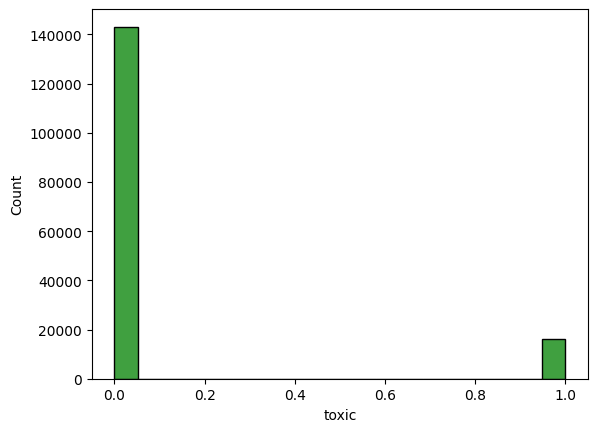

In [6]:
fig = sns.histplot(data=df['toxic'], color = 'green')
plt.show()

Мы видим большой перевес в сторону нетоксичных комментариев.

Напишем функцию для лемматизации

In [7]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    token = nltk.word_tokenize(text)  #разобьем исходный текст на токены(слова)
    lemm_text = ' '.join([lemmatizer.lemmatize(w) for w in token]) #лемматизируем каждое слово и объединяем в строку
            
    return lemm_text

Теперь напишем функцию, которая оставит в тексте только кириллические символы и пробелы.

In [8]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear_text = clear_text.split()
    clear_text = " ".join(clear_text)
    return clear_text

Перезапишеи столбец text очищенными строками

In [9]:
df['text'] = df['text'].progress_apply(clear_text)

A Jupyter Widget

In [10]:
df.head() #посмотрим, что полчилось

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d aww he matches this background colour i m se...,0
2,2,hey man i m really not trying to edit war it s...,0
3,3,more i can t make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0


Добавим столбец lemm_text с обработанными строками к датасету.

In [11]:
df['lemm_text'] = df['text'].progress_apply(lemmatize)

A Jupyter Widget

In [12]:
df.head(5) #посмотрим, что полчилось

,Unnamed: 0,text,toxic,lemm_text
0,0,explanation why the edits made under my userna...,0,explanation why the edits made under my userna...
1,1,d aww he matches this background colour i m se...,0,d aww he match this background colour i m seem...
2,2,hey man i m really not trying to edit war it s...,0,hey man i m really not trying to edit war it s...
3,3,more i can t make any real suggestions on impr...,0,more i can t make any real suggestion on impro...
4,4,you sir are my hero any chance you remember wh...,0,you sir are my hero any chance you remember wh...


Открыли и изучили датасет, привели все слова к нижнему регистру. Далее провели лемматизацию и почистили данные от различных символов, оставив только киррилические и пробелы.

## Обучение

Разделим датасет на выборки

In [13]:
target = df['toxic']
features = df['lemm_text']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

Найдем стоп-слова

In [14]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=list(stopwords)) 

Теперь переведем слова в векторы и посчитаем tf_idf

In [15]:
tf_idf_train = count_tf_idf.fit_transform(features_train)
tf_idf_test = count_tf_idf.transform(features_test)

Логистическая регрессия

In [27]:
param_grid = {'model__C':[1, 5, 10]}
pipeline = Pipeline([('model',LogisticRegression(class_weight='balanced', solver = 'liblinear', random_state = 12345))])
grid_lg = GridSearchCV(pipeline, cv=3, n_jobs=-1, param_grid=param_grid, verbose = 0, scoring='f1')
grid_lg.fit(tf_idf_train, target_train)
print('Лучшее значение ', grid_lg.best_params_, 'F1:', grid_lg.best_score_)

Лучшее значение  {'model__C': 5} F1: 0.7605292409430611


F1 = 0.7605, по заданию результат подходит

Дерево решений

In [28]:
param_grid = {'max_depth' : range(1, 20),
              'criterion' :['gini', 'entropy']
             }
model_tree = DecisionTreeClassifier(random_state=12345)
grid_tr = GridSearchCV(estimator = model_tree, param_grid = param_grid, cv = 3, verbose = 0, n_jobs = -1, scoring='f1').fit(tf_idf_train, target_train)

print('Лучшие значения глубины и estimators', grid_tr.best_params_, 'F1:', grid_tr.best_score_)

Лучшие значения глубины и estimators {'criterion': 'gini', 'max_depth': 19} F1: 0.6433602579042614


F1 = 0.64 - не подходит

Модель LGBMClassifier

In [29]:
model_lgbm = LGBMClassifier()

param_grid = {'n_estimators': [50, 75, 100],
             'learning_rate': [0.01, 0.05, 0.1, 0.3],
             'num_leaves': [10, 20, 30, 40]}

grid_lgbm = GridSearchCV(estimator = model_lgbm, param_grid = param_grid, cv = 3, n_jobs = -1, scoring = 'f1')
grid_lgbm.fit(tf_idf_train, target_train)

print('Лучшие значения глубины и estimators', grid_lgbm.best_params_, 'F1:', grid_lgbm.best_score_)

Лучшие значения глубины и estimators {'learning_rate': 0.3, 'n_estimators': 100, 'num_leaves': 40} F1: 0.7645927189103047


F1 = 0.7645 Это выше, чем требовалось, значит будем теперь проверять модель на тестовой выборке.

Cоберем все результаты в таблицу для наглядности

In [30]:
results = {'Модель': ['LinearRegression', 'DecisionTree', 'LGBMClassifier'], 
           'F1': [0.7605, 0.6433, 0.7645],
           }
results = pd.DataFrame(data=results)
results

,Модель,F1
0,LinearRegression,0.7605
1,DecisionTree,0.6433
2,LGBMClassifier,0.7645


Лучший результат с метрикой F1 = 0.7645 показала модель LGBMClassifier. Будем тестировать на ней.

In [31]:
prediction = grid_lgbm.predict(tf_idf_test)
print("F1_score:", f1_score(target_test, prediction))

F1_score: 0.7781967775111416


F1 = 0.77, хороший результат.

Построим матрицу ошибок

Text(0.5, 1.0, 'Матрица ошибок')

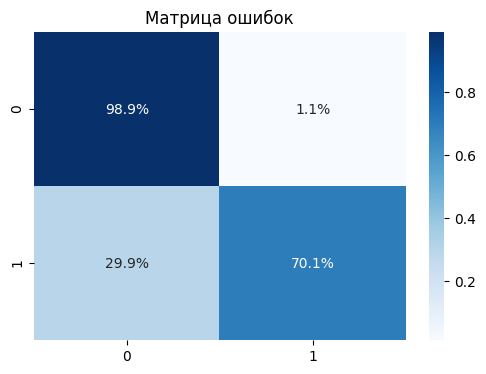

In [32]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(target_test, prediction, normalize='true'),annot=True,fmt='.1%',cmap="Blues")
plt.title('Матрица ошибок')

После разделения датасета на обучающую и тестовую выборки, мы обучили модели логистической регрессии, дерево решений и LGBMClassifier (на самом деле обучал еще случафный лес, но там F1 = 0.23, поэтому не стал оставлять и Catboost даже на минималках не смог дождаться ответа). Лучший результат F1 = 0.76 показала модель LGBMClassifier, поэтому проверили тестовую выборку на данной модели и получили результат F1 = 0.77.

## Выводы

Проанализировав полученный датасет, привели все слова к нижнему регистру. Далее провели лемматизацию и почистили данные от различных символов, оставив только киррилические и пробелы.Увидели, что имеется значительный перевес в сторону нормальных комментариев. Далее разделили датасет на тренировочную и тестовую выборки и провели обучение моделей: логистическая регрессия, дерево решений и LGBMClassifier. Исходя из требований заказчика, мы должны были получить метрику F1 не менее 0.75. Лучший результат F1 = 0.76 показала модель LGBMClassifier, ее мы и выбрали для дальнейшей проверки на тестовой выборке. Результат улучшился, F1 = 0.77, таким образом, задача заказчика выполнена.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны